In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import mutual_info_score,homogeneity_completeness_v_measure,silhouette_score, accuracy_score
from sklearn.mixture import GaussianMixture
import csv
import matplotlib.pyplot as plt
from itertools import groupby
import operator
from sklearn.model_selection import train_test_split

In [2]:
def get_score(model, X, y, mapper):
    pred = model.predict(X)
    pred_act = [mapper[i] for i in pred]
    return accuracy_score(pred_act, y)

# Wine Quality Dataset

In [3]:
def get_cat(x):
    if x < 6: return 'bad'
    else: return 'good'


def get_data(file):
    data = pd.read_csv(file)
    categorical_vars =["class"]
    
    df = data.copy()
    
    for var, value in df.iteritems():
        if var not in categorical_vars:
            df[var] = (df[var]-df[var].mean())/df[var].std()

    return df

df = get_data("wine_dataset.csv")

y = df['class'].values
X = df.drop(['class'], axis=1)
df.tail()

,class,Alcohol,Malic_acid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,Od_Hod_of_diluted_wines,Proline
3152,3,0.415589,0.254163,0.188519,3.001047,-0.340468,-1.146502,-1.467846,0.287709,-0.901624,1.099993,1.517704,-1.723028,-0.287231
3153,1,-0.756533,-0.542201,-0.512479,3.064172,1.297913,-0.159682,0.250942,0.498601,-1.231649,-0.155276,-0.175866,1.216221,1.841367
3154,1,0.504843,-0.492588,1.895604,3.138160,0.579143,0.642725,0.761415,1.799971,1.106230,0.424051,1.188602,0.043996,2.097635
3155,3,0.909479,1.613956,1.870913,3.159155,-0.729241,0.561769,0.666325,1.139906,1.062602,-0.069268,-0.449447,-0.851747,-0.117785
3156,1,0.608583,-0.769603,1.569281,3.231870,0.756223,2.336953,-0.203921,-0.848322,-0.042762,-0.317905,-0.615134,0.382382,0.845015


### KMeans

In [4]:
results_kmeans = []
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=7)
import collections

for k in range(5, 51, 5):
    print(f"K={k}")
    k_model = KMeans(n_clusters=k, max_iter=300)
    k_model.fit(X_train)
    
    mapping = list(zip(k_model.labels_, y_train))
    mapper = {}
    for key, group in groupby(sorted(mapping), operator.itemgetter(0)):
        lst = [item[1] for item in list(group)]
        cls = max(set(lst),key=lst.count)
        mapper[key]=cls
        
    homogenity, completeness, _ = homogeneity_completeness_v_measure(k_model.labels_, y_train)
    s_score = silhouette_score(X_train, k_model.labels_)
    mi = mutual_info_score(y_train, k_model.labels_)

    train_accuracy = get_score(k_model, X_train, y_train, mapper)
    test_accuracy = get_score(k_model, X_test, y_test, mapper)

    
    record = [k, homogenity, completeness, s_score, mi, k_model.inertia_, train_accuracy, test_accuracy]
    
    results_kmeans.append(record)

with open("D2_KM.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(results_kmeans)

K=5
K=10
K=15
K=20
K=25
K=30
K=35
K=40
K=45
K=50


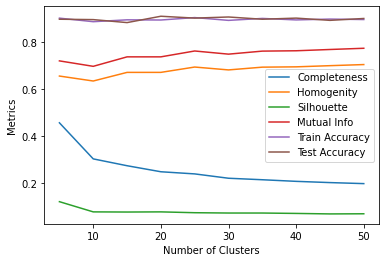

In [5]:
plt.figure()
plt.xlabel("Number of Clusters")
plt.ylabel("Metrics")

completeness_scores = []
homogenity_scores = []
s_scores = []
mis = []
ks = []
inertia = []
tr_acc = []
te_acc = []

for record in results_kmeans:
    ks.append(record[0])
    completeness_scores.append(record[1])
    homogenity_scores.append(record[2])
    s_scores.append(record[3])
    mis.append(record[4])
    inertia.append(record[5])
    tr_acc.append(record[6])
    te_acc.append(record[7])

plt.plot(ks, completeness_scores, label='Completeness')
plt.plot(ks, homogenity_scores, label='Homogenity')
plt.plot(ks, s_scores, label='Silhouette')
plt.plot(ks, mis, label='Mutual Info')
plt.plot(ks, tr_acc, label='Train Accuracy')
plt.plot(ks, te_acc, label='Test Accuracy')
plt.legend(loc="best")

plt.savefig("Data2-KMeans.png")

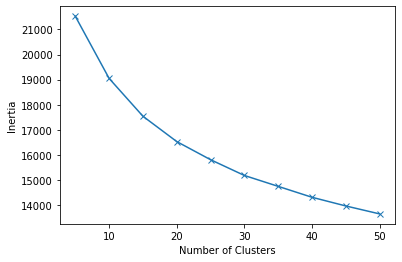

In [6]:
plt.figure()
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.plot(ks, inertia, marker='x')
plt.savefig("Elbow-D2.png")

In [12]:
results_gmm = []
for k in range(2, 51, 2):
    print(f"K={k}")
    g_model = GaussianMixture(n_components=k, random_state=7)
    g_model.fit(X_train)
    pred = g_model.predict(X_train)

    mapping = list(zip(pred, y_train))
    for key, group in groupby(sorted(mapping), operator.itemgetter(0)):
        lst = [item[1] for item in list(group)]
        
        cls = max(set(lst),key=lst.count)
        mapper[key]=cls
    
    homogenity, completeness, _ = homogeneity_completeness_v_measure(pred, y_train)
    s_score = silhouette_score(X_train, pred)
    mi = mutual_info_score(y_train, pred)
    
    train_accuracy = get_score(g_model, X_train, y_train, mapper)
    test_accuracy = get_score(g_model, X_test, y_test, mapper)
    
    record = [k, homogenity, completeness, s_score, mi, g_model.score(X), train_accuracy, test_accuracy, g_model.bic(X_train)]
    results_gmm.append(record)

with open("D2_EM.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(results_gmm)

K=2
K=4
K=6
K=8
K=10
K=12
K=14
K=16
K=18
K=20
K=22
K=24
K=26
K=28
K=30
K=32
K=34
K=36
K=38
K=40
K=42
K=44
K=46
K=48
K=50


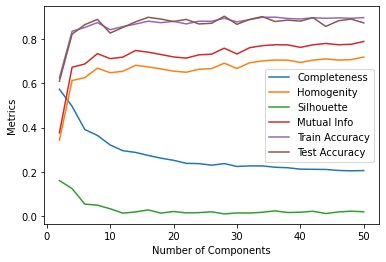

In [13]:
plt.figure()
plt.xlabel("Number of Components")
plt.ylabel("Metrics")

completeness_scores = []
homogenity_scores = []
s_scores = []
mis = []
ks = []
tr_acc = []
te_acc = []
scores = []
bic = []

for record in results_gmm:
    ks.append(record[0])
    completeness_scores.append(record[1])
    homogenity_scores.append(record[2])
    s_scores.append(record[3])
    mis.append(record[4])
    scores.append(record[5])
    tr_acc.append(record[6])
    te_acc.append(record[7])
    bic.append(record[8])

plt.plot(ks, completeness_scores, label='Completeness')
plt.plot(ks, homogenity_scores, label='Homogenity')
plt.plot(ks, s_scores, label='Silhouette')
plt.plot(ks, mis, label='Mutual Info')
plt.plot(ks, tr_acc, label='Train Accuracy')
plt.plot(ks, te_acc, label='Test Accuracy')
plt.legend(loc="best")

plt.savefig("Data2-EM.png")

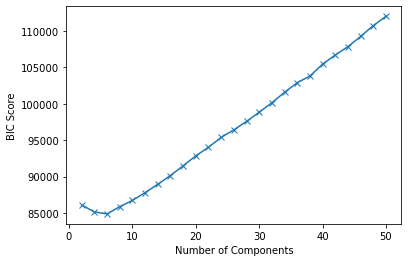

In [14]:
plt.figure()
plt.xlabel("Number of Components")
plt.ylabel("BIC Score")
plt.plot(ks, bic, marker='x')
plt.savefig("Cost-D2.png")

# Phishing Websites Dataset Analysis

In [15]:
from scipy.io.arff import loadarff 

raw_data = loadarff('Training Dataset.arff')
ph_data = pd.DataFrame(raw_data[0])
ph_data.head()

for var in ph_data.columns.values:
    ph_data[var] = pd.Categorical(ph_data[var])
    ph_data[var] = ph_data[var].cat.codes
    
y = ph_data.Result.values
X = ph_data.drop(['Result'], axis=1)

### K-Means 

In [16]:
results_kmeans = []
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=7)
import collections

for k in range(5, 51, 5):
    print(f"K={k}")
    k_model = KMeans(n_clusters=k, max_iter=300)
    k_model.fit(X_train)
    
    mapping = list(zip(k_model.labels_, y_train))
    mapper = {}
    for key, group in groupby(sorted(mapping), operator.itemgetter(0)):
        lst = [item[1] for item in list(group)]
        cls = max(set(lst),key=lst.count)
        mapper[key]=cls
        
    homogenity, completeness, _ = homogeneity_completeness_v_measure(k_model.labels_, y_train)
    s_score = silhouette_score(X_train, k_model.labels_)
    mi = mutual_info_score(y_train, k_model.labels_)

    train_accuracy = get_score(k_model, X_train, y_train, mapper)
    test_accuracy = get_score(k_model, X_test, y_test, mapper)

    
    record = [k, homogenity, completeness, s_score, mi, k_model.inertia_, train_accuracy, test_accuracy]
    
    results_kmeans.append(record)

with open("D1_KM.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(results_kmeans)

K=5
K=10
K=15
K=20
K=25
K=30
K=35
K=40
K=45
K=50


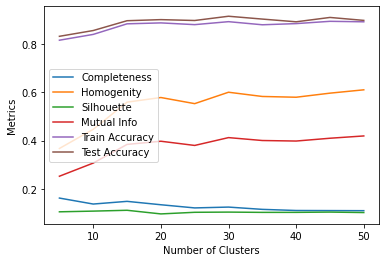

In [17]:
plt.figure()
plt.xlabel("Number of Clusters")
plt.ylabel("Metrics")

completeness_scores = []
homogenity_scores = []
s_scores = []
mis = []
ks = []
inertia = []
tr_acc = []
te_acc = []

for record in results_kmeans:
    ks.append(record[0])
    completeness_scores.append(record[1])
    homogenity_scores.append(record[2])
    s_scores.append(record[3])
    mis.append(record[4])
    inertia.append(record[5])
    tr_acc.append(record[6])
    te_acc.append(record[7])

plt.plot(ks, completeness_scores, label='Completeness')
plt.plot(ks, homogenity_scores, label='Homogenity')
plt.plot(ks, s_scores, label='Silhouette')
plt.plot(ks, mis, label='Mutual Info')
plt.plot(ks, tr_acc, label='Train Accuracy')
plt.plot(ks, te_acc, label='Test Accuracy')
plt.legend(loc="best")

plt.savefig("Data1-KMeans.png")

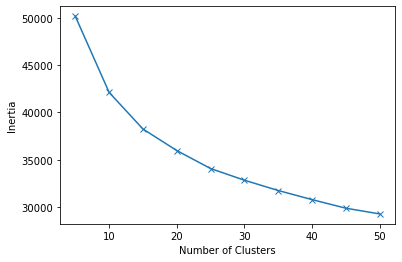

In [18]:
plt.figure()
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.plot(ks, inertia, marker='x')
plt.savefig("Elbow-D1.png")

### Expectation Maximization

In [22]:
results_gmm = []
for k in range(2, 51, 2):
    print(f"K={k}")
    g_model = GaussianMixture(n_components=k, random_state=7)
    g_model.fit(X_train)
    pred = g_model.predict(X_train)
    
    mapping = list(zip(pred, y_train))
    for key, group in groupby(sorted(mapping), operator.itemgetter(0)):
        lst = [item[1] for item in list(group)]
        
        cls = max(set(lst),key=lst.count)
        mapper[key]=cls
    
    homogenity, completeness, _ = homogeneity_completeness_v_measure(pred, y_train)
    s_score = silhouette_score(X_train, pred)
    mi = mutual_info_score(y_train, pred)
    
    train_accuracy = get_score(g_model, X_train, y_train, mapper)
    test_accuracy = get_score(g_model, X_test, y_test, mapper)
    
    record = [k, homogenity, completeness, s_score, mi, g_model.score(X), train_accuracy, test_accuracy, g_model.bic(X_train)]
    results_gmm.append(record)

with open("D1_EM.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(results_gmm)

K=2
K=4
K=6
K=8
K=10
K=12
K=14
K=16
K=18
K=20
K=22
K=24
K=26
K=28
K=30
K=32
K=34
K=36
K=38
K=40
K=42
K=44
K=46
K=48
K=50


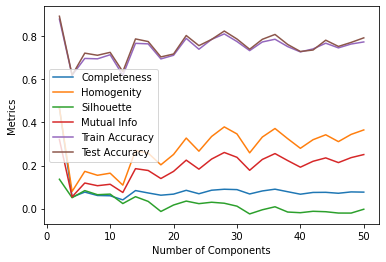

In [25]:
plt.figure()
plt.xlabel("Number of Components")
plt.ylabel("Metrics")

completeness_scores = []
homogenity_scores = []
s_scores = []
mis = []
ks = []
tr_acc = []
te_acc = []
scores = []
bic = []

for record in results_gmm:
    ks.append(record[0])
    completeness_scores.append(record[1])
    homogenity_scores.append(record[2])
    s_scores.append(record[3])
    mis.append(record[4])
    scores.append(record[5])
    tr_acc.append(record[6])
    te_acc.append(record[7])
    bic.append(record[8])

plt.plot(ks, completeness_scores, label='Completeness')
plt.plot(ks, homogenity_scores, label='Homogenity')
plt.plot(ks, s_scores, label='Silhouette')
plt.plot(ks, mis, label='Mutual Info')
plt.plot(ks, tr_acc, label='Train Accuracy')
plt.plot(ks, te_acc, label='Test Accuracy')
plt.legend(loc="best")

plt.savefig("Data1-EM.png")

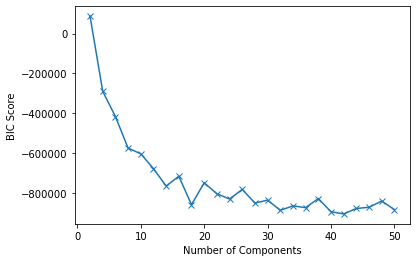

In [26]:
plt.figure()
plt.xlabel("Number of Components")
plt.ylabel("BIC Score")
plt.plot(ks, bic, marker='x')
plt.savefig("Cost-D1.png")